Το πρόγραμμα τρέχει στο τερματικό με την εντολή <br>
'python part1.py <image_path> <local_model_path>' ή <br>
'python part1.py <image_path>'<br>
το local_model_path είναι προαιρετικό και χρησιμοποιείται για να μην καθηστερούν οι δοκιμές κατεβάζοντας συνέχεια το model.

In [13]:
import os
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
#from sys import argv #in the original
from random import randint

In [14]:
#This is the model from deeplab_model.ipynb
class DeepLabModel(object):
	INPUT_TENSOR_NAME = 'ImageTensor:0' #first operation
	OUTPUT_TENSOR_NAME = 'SemanticPredictions:0' #last operation
	INPUT_SIZE = 513 #the size that the image will be resized to
	FROZEN_GRAPH_NAME = 'frozen_inference_graph' #name of the graph file

	def __init__(self, tarball_path):
		self.graph = tf.Graph()

		graph_def = None
		#Extract frozen graph from tar archive.
		#by opening the tar and looking for the 'FROZEN_GRAPH_NAME' file
		tar_file = tarfile.open(tarball_path)
		for tar_info in tar_file.getmembers():
			if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
				file_handle = tar_file.extractfile(tar_info)
				graph_def = tf.GraphDef.FromString(file_handle.read())
				break

		tar_file.close()

		if graph_def is None:
			raise RuntimeError('Cannot find inference graph in tar archive.')
		
		#add the operations of the FROZEN_GRAPH_NAME to the graph
		with self.graph.as_default():
			tf.import_graph_def(graph_def, name='')
		#start the session to execute the graph operations
		self.sess = tf.Session(graph=self.graph)

	def run(self, image):
		#resize image
		width, height = image.size #get original size
		resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) 
		target_size = (int(resize_ratio * width), int(resize_ratio * height)) #get size
		resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS) #resize image
		#run session with the resized image
		batch_seg_map = self.sess.run(
				self.OUTPUT_TENSOR_NAME,
				feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
		seg_map = batch_seg_map[0]
		return resized_image, seg_map

In [35]:
def vis_segmentation(image, seg_map):
	"""Visualizes input image, segmentation map and overlay view."""
	plt.figure(figsize=(15, 5))
	grid_spec = gridspec.GridSpec(1, 3, width_ratios=[6, 6, 1])
	#show original image
	plt.subplot(grid_spec[0])
	plt.imshow(image)
	plt.axis('off')
	plt.title('input image')
	#show "colorized" image
	plt.subplot(grid_spec[1])
	seg_image = FULL_COLOR_MAP[seg_map]
	plt.imshow(seg_image)
	plt.axis('off')
	plt.title('segmentation map')
	#show color-label matching
	unique_labels = np.unique(seg_map)
	ax = plt.subplot(grid_spec[2])
	plt.imshow(np.array([[FULL_COLOR_MAP[i]] for i in unique_labels]).astype(np.uint8), interpolation='nearest')
	ax.yaxis.tick_right()
	plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
	plt.xticks([])
	ax.tick_params(width=0.0)
	plt.grid('off')
	plt.show()

In [23]:
#custom colormap that splits the spectrum equally according to the number of labels we have
def colormap(labels):
	n = len(labels)
	colors = (2**25-1)//n
	result = []
	for c in range(n):
		color1 = c * colors
		color2 = color1 >> 8
		color3 = (color2 >> 8) & 255
		color1, color2 = color1 & 255, color2 & 255
		result.append([color3, color2, color1])
	return np.array(result)

In [17]:
def main(image):
	#open image
	img = Image.open(image)
	#run the model from the example
	resized_im, seg_map = MODEL.run(img)
	#show results
	vis_segmentation(resized_im, seg_map)

In [36]:
#just for testing so that you don't have to download the model every time
argv=['','image name','deeplab_model4.tar.gz']#using a local model ('mobilenetv2_coco_voctrainaug') only for the test
if len(argv) < 2:
	_DOWNLOAD_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'#model url
	_TARBALL_NAME = 'deeplab_model.tar.gz'#name of the downloaded temp file
	model_dir = tempfile.mkdtemp()
	tf.gfile.MakeDirs(model_dir)
    
	download_path = os.path.join(model_dir, _TARBALL_NAME)
	print('downloading model, this might take a while...')
	urllib.request.urlretrieve(_DOWNLOAD_URL, download_path)
	print('download completed! loading DeepLab model...')
else:
	download_path = argv[2]
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')
#model labels
LABEL_NAMES = np.asarray([
		'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
		'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
		'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])
FULL_COLOR_MAP = colormap(LABEL_NAMES)

model loaded successfully!


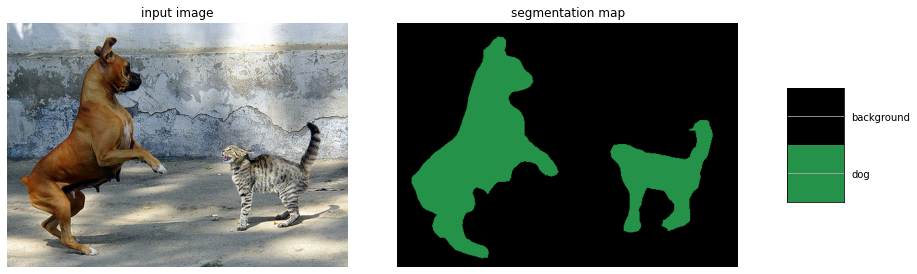

In [37]:
main('image2.jpg')#it finds both animals but instead of a dog an a cat it finds 2 dogs

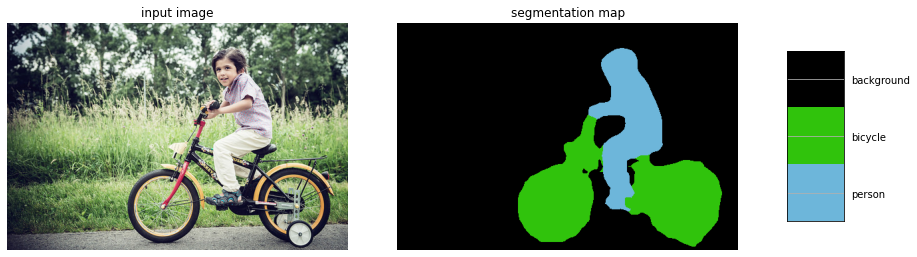

In [38]:
main('image1.jpg')#here it identifies both the child and the bicycle correctly

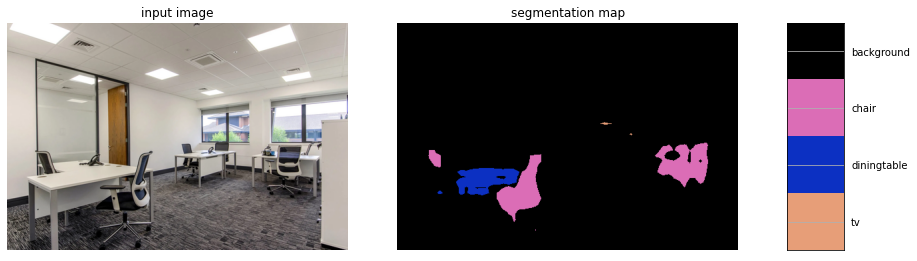

In [39]:
main('office.jpg')
#in this image it identifies 4 chairs correctly 
#it thinks that the desk is a dining table and that the window is a tv though

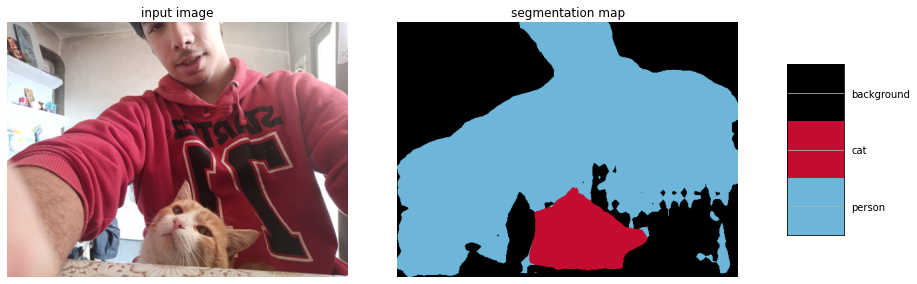

In [40]:
main('image4.jpg')#here it found both me and my cat woth the correct label

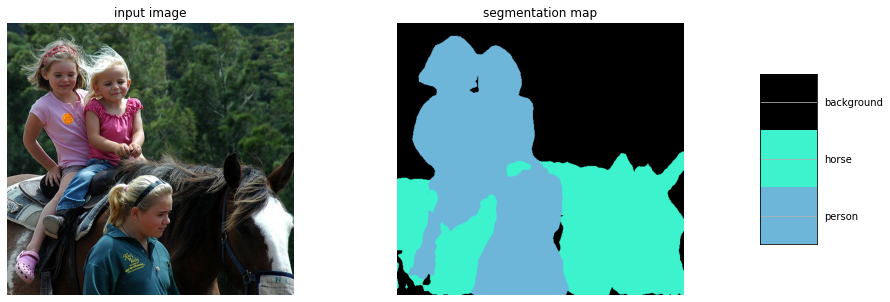

In [41]:
main('image3.jpg')#it sees all 3 girls as people and the horse correctly 